# Imports

In [ ]:
!pip install --upgrade cvxpy
!pip install mosek

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.4 MB 25.8 MB/s 


In [ ]:
from sklearn import linear_model
from scipy.optimize import curve_fit
from scipy.optimize import nnls
import cvxpy as cp
import numpy as np
import scipy as sp
# import dykstra 
import matplotlib.pyplot as plt
# import pwlf
import matplotlib.animation as animation
from matplotlib import rc

rc('animation', html='jshtml')

In [ ]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

# Dynamic Fisher Market w/ linear Fitted Value Iteration

## Library

#### Utilities

In [ ]:
################### Utility Functions ##########################

def get_linear_util(demands, valuations):
    util = np.sum(demands * valuations, axis = 1) 
    return util


def get_leontief_util(demands, valuations):
    util =  np.min(demands/valuations.clip(min = 0.001), axis = 1) 
    return util

def get_cd_util(demands, valuations):
    demands = demands * 1e5
    util = np.sum(np.log(demands.clip(min = 0.001))*valuations, axis = 1) 
    return util


#################### Utility Gradient Functions #####################
def get_linear_util_gradient(allocations, valuations):
    return valuations

def get_leontief_util_gradient(allocations, valuations):
    grad_matrix = []
    argmins = np.argmin(allocations/valuations.clip(min = 0.001), axis = 0)
    marginal_utils = np.zeros(allocations.shape)
    
    for buyer in range(allocations.shape[0]):
      marginal_utils[buyer, argmins[buyer] ] = 1 / valuations[buyer, argmins[buyer]].clip(min = 0.001)
    
    return marginal_utils

def get_cd_util_gradient(allocations, valuations):
    # return ( np.prod(np.power(allocations, valuations), axis = 1)*( valuations / allocations.clip(min = 0.001) ).T).T
    return ( valuations / allocations.clip(min = 0.001) )
################### Projection Onto Budget Set ##########################


def project_onto_half_space(X, beta, p, b):
  offsets = ((X @ p + beta - b).clip(min= 0))/(np.linalg.norm(p)**2).clip(min= 10e-5)

  X_proj = X - (offsets*np.tile(p, reps = (b.shape[0], 1)).T).T
  beta_proj = beta - offsets
  
  return (X_proj, beta_proj)


def project_onto_positive_ortanth(X, beta, p, b):

  return (X.clip(min = 0), beta.clip(min = 0))

def project_to_bugdet_set(X, beta, p, b):
  iter = 0
  P_X, P_beta = np.zeros(X.shape), np.zeros(b.shape[0])
  Q_X, Q_beta = np.zeros(X.shape), np.zeros(b.shape[0])
  X_proj_y, beta_proj_y = X, beta
  X_proj_x, beta_proj_x = np.ones(X.shape), np.ones(b.shape[0])
  
  X_proj_prev, beta_proj_prev = X.copy(), beta.copy()
  change = float("inf")
  iter = 0
  while np.any(X_proj_x @ p + beta_proj_x - b >  10e-4) or np.any(X_proj_x < 0) or np.any(beta_proj_x < 0) :
  # while iter <= 1000:
    iter += 1
    # print("iterations", iter, "error: ", change)
    X, beta = project_onto_positive_ortanth(X, beta )
    X, beta = project_onto_half_space(X, beta )
    
    # print("proj", X_proj_x, beta_proj_x)
    P_X, P_beta = (P_X + X_proj_y - X_proj_x, P_beta + beta_proj_y - beta_proj_x)
    X_proj_y, beta_proj_y = project_onto_half_space(X_proj_x + Q_X, beta_proj_x + Q_beta, p, b)
    Q_X, Q_beta = Q_X + X_proj_x - X_proj_y, Q_beta + beta_proj_x- beta_proj_y
    
    change = np.linalg.norm(X_proj_prev - X_proj_x) + np.linalg.norm(beta_proj_prev - beta_proj_x)
    X_proj_prev, beta_proj_prev = X_proj_x.copy(), beta_proj_x.copy()
  
  assert np.all(X_proj_x @ p + beta_proj_x - b <=  10e-2) and np.all(X_proj_x >= 0) and np.all(beta_proj_x >= 0) 
  # print("proj", X_proj_x, beta_proj_x)
  return X_proj_x, beta_proj_x
  # shadow_demands = np.zeros((X.shape[0], X.shape[1] + 1))
  # shadow_prices = np.zeros(X.shape[1] + 1)
  # shadow_demands[:, :-1] = X 
  # shadow_demands[:, -1] = beta

  # shadow_prices[:-1] = p
  # shadow_prices[-1] = 1
  
  # P, Q = np.zeros((X.shape[0], X.shape[1] + 1))
  # (1/np.linalg.norm(shadow_prices)**2).clip(min= 0.00000001)*((shadow_demands @ shadow_prices - b).clip(min= 0)* np.tile(shadow_prices, reps = (b.shape[0], 1)).T).T
  # while (np.linalg.norm((shadow_demands @   shadow_prices - b).clip(min = 0)) < 1):
      
  #     shadow_demands -= (1/np.linalg.norm(shadow_prices)**2).clip(min= 0.00000001)*((shadow_demands @ shadow_prices - b).clip(min= 0)* np.tile(shadow_prices, reps = (b.shape[0], 1)).T).T
  #     shadow_demands = shadow_demands.clip(min = 0)
      
  
  
  # return (shadow_demands[:, :-1], shadow_demands[:, -1])

################### Min-Max Objective Functions ##########################

def get_linear_obj(prices, demands, budgets, valuations):
  utils = np.sum(valuations * demands, axis = 1)
  return np.sum(prices) + budgets @ np.log(utils.clip(min=0.0001))


def get_leontief_obj(prices, demands, budgets, valuations):
    utils = np.min(demands/valuations, axis = 1)
    return np.sum(prices) + budgets @ np.log(utils.clip(min=0.0001))


def get_cd_obj(prices, demands, budgets, valuations):
    utils = np.prod(np.power(demands, valuations), axis= 1)
    return np.sum(prices) + budgets @ np.log(utils.clip(min=0.0001))


################### Heuristic objective function ##########################
def get_global(X, get_obj, prices, budgets, valuations, value_coef, value_intercept):
  num_buyers = budgets.shape[0]
  num_goods = prices.shape[0]
  X = X.reshape((num_buyers, num_goods + 1))
  
  demands = X[:, :-1]
  savings = X[:, -1]
  demands = demands.clip(min = 0.0001)
  savings = savings.clip(min = 0.0001)
  
  return -(get_obj(prices, demands, budgets-savings, valuations) + discount*(value_coef.T @ savings + value_intercept) )

### Test JAX

In [ ]:
from jax import device_put

demands = np.random.rand(2,2)
demand=demands[0]
demand = device_put(demand)
valuations = np.array([[21.26920423, 33.45640665],
 [45.06020981, 23.52635807]])
valuation = device_put(valuations[0])

#### Linear

In [ ]:
def get_linear_obj(prices, demands, budgets, valuations):
  utils = jnp.sum(valuations * demands, axis = 1)
  return jnp.sum(prices) + jnp.dot(budgets, jnp.log(utils.clip(0.001)))

def get_linear_value(prices, demands, savings, budgets, valuations, discount, value_coef, value_intercept):
  next_budgets = savings + jnp.array([9.5, 9.5])
  return get_linear_obj(prices, demands, budgets-savings, valuations) + discount*(next_budgets.T @ value_coef + value_intercept)

prices = device_put(np.array([10.0,10.0]))
demands = device_put(np.array([[2.0,2.1],[2.2,2.3]]))
budgets = device_put(np.array([10,10]))
savings = device_put(np.array([0.01,0.01]))
value_coef = device_put(np.repeat(0,2.0))
value_intercept = 10.0

print(get_linear_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))


demands_grad_linear_value = grad(jit(get_linear_value), argnums=1)
savings_grad_linear_value = grad(jit(get_linear_value), argnums=2)
print("___________________JAX___________________")
print(demands_grad_linear_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))
print(savings_grad_linear_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))


spendings = budgets - savings
utils = get_linear_util(demands, valuations).clip(min = 0.01)
marginals = get_linear_util_gradient(demands, valuations)
demands_step = (((spendings/utils)*marginals.T)).T
savings_step = -np.log(utils) + 0.9*value_coef
print("___________________BY HAND___________________")
print(demands_step)
print(savings_step)

126.47856
___________________JAX___________________
[[1.8837347 2.96311  ]
 [2.9374995 1.5336959]]
[-4.7255883 -5.0320253]
___________________BY HAND___________________
[[1.8837347 2.96311  ]
 [2.9374995 1.5336959]]
[-4.7255883 -5.0320253]


#### leontief

In [ ]:
def get_leontief_obj(prices, demands, budgets, valuations):
  utils = jnp.min(demands/valuations, axis = 1) 
  return jnp.sum(prices) + jnp.dot(budgets, jnp.log(utils))

def get_leontief_value(prices, demands, savings, budgets, valuations, discount, value_coef, value_intercept):
  next_budgets = savings + jnp.array([9.5, 9.5])
  return get_leontief_obj(prices, demands, budgets-savings, valuations) + discount*(next_budgets.T @ value_coef + value_intercept)

prices = device_put(np.array([10.0,10.0]))
demands = device_put(np.array([[1.2,2],[0.31, 2.31]]))
budgets = device_put(np.array([10,10]))
savings = device_put(np.array([0.01,0.01]))
value_coef = device_put(np.repeat(0,2.0))
value_intercept = 10.0

print(get_leontief_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))


demands_grad_leontief_value = grad(jit(get_leontief_value), argnums=1)
savings_grad_leontief_value = grad(jit(get_leontief_value), argnums=2)
print("___________________JAX___________________")
print(demands_grad_leontief_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))
print(savings_grad_leontief_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))

spendings = budgets - savings
utils = get_leontief_util(demands, valuations).clip(min = 0.01)
marginals = get_leontief_util_gradient(demands, valuations)
demands_step = (((spendings/utils)*marginals.T)).T
savings_step = -np.log(utils) + 0.9*value_coef
print("___________________BY HAND___________________")
print(demands_step)
print(savings_step)

-49.46267
___________________JAX___________________
[[ 8.324999  0.      ]
 [32.225807  0.      ]]
[2.8749387 4.9791827]
___________________BY HAND___________________
[[ 0.        5.292443]
 [22.170336  0.      ]]
[2.8749387 4.6051702]


#### CD

In [ ]:
val_sum = np.sum(valuations)

In [ ]:
def get_cd_obj(prices, demands, budgets, valuations):
  normalized_vals = valuations / val_sum
  utils = jnp.prod(jnp.power(demands, normalized_vals), axis= 1)
  return jnp.sum(prices) + jnp.dot(budgets, jnp.log(utils.clip(0.001)))

def get_cd_value(prices, demands, savings, budgets, valuations, discount, value_coef, value_intercept):
  next_budgets = savings + jnp.array([9.5, 9.5])
  return get_cd_obj(prices, demands, budgets-savings, valuations) + discount*(next_budgets.T @ value_coef + value_intercept)

prices = device_put(np.array([10.0,10.0]))
demands = device_put(np.array([[0.58332625, 0.7736752 ],
 [0.8184732,  0.5077449 ]]))
budgets = device_put(np.array([10,10]))
savings = device_put(np.array([0.01,0.01]))
value_coef = device_put(np.repeat(0,2.0))
value_intercept = 10.0

print(get_cd_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))


demands_grad_cd_value = grad(jit(get_cd_value), argnums=1)
savings_grad_cd_value = grad(jit(get_cd_value), argnums=2)
print("___________________JAX___________________")
print(demands_grad_cd_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))
print(savings_grad_cd_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))

spendings = budgets - savings
utils = get_cd_util(demands, valuations).clip(min = 0.01)
marginals = get_cd_util_gradient(demands, valuations)
demands_step = (((spendings/utils)*marginals.T)).T
savings_step = -np.log(utils) + 0.9*value_coef
print("___________________BY HAND___________________")
print(demands_step)
print(savings_step)

25.352663
___________________JAX___________________
[[2.9539237 3.5033221]
 [4.4601374 3.7537787]]
[0.16258979 0.20250894]
___________________BY HAND___________________
[[0.5971364  0.7081975 ]
 [0.7192597  0.60534936]]
[-6.413463  -6.6394315]


## Nested Gradient Descent Ascent based Solution

#### Min_Max step

##### Min_Max Step with cvxpy Projection

In [ ]:
def min_max_linear_value_cvx_project(budgets, valuations, value_coef, value_intercept, discount, learn_rate_prices, learn_rate_demands, 
                         num_iters_prices, num_iters_demands, utility_type):
  prices = np.zeros(valuations.shape[1]).clip(min=0.1)
  # print(f"valuations: {valuations}")
  if utility_type == "linear":
      get_util = get_linear_util
      get_marginal_util = get_linear_util_gradient
      get_obj = get_linear_obj

  elif utility_type == "leontief":
      get_util = get_leontief_util
      get_marginal_util = get_leontief_util_gradient
      get_obj = get_leontief_obj

  elif utility_type == "cd":
      get_util = get_cd_util
      get_marginal_util = get_cd_util_gradient
      get_obj = get_cd_obj

  prices_step_sizes = []
  demands_step_sizes= []
  savings_step_sizes = []
      

  num_buyers = budgets.shape[0]
  num_goods = prices.shape[0]
  
  allocation = cp.Variable((num_buyers, num_goods))
  saving = cp.Variable(num_buyers)
  p = cp.Parameter(num_goods)
  b = cp.Parameter(num_buyers)  
  beta = cp.Parameter(num_buyers) 
  X = cp.Parameter((num_buyers, num_goods))

  obj = cp.Minimize( cp.sum(cp.power(cp.norm(X - allocation, axis = 1), 2)) + cp.sum(cp.power(saving - beta, 2)))
  # obj = cp.Minimize( cp.sum(cp.norm(X - allocation, axis = 1)) + cp.norm(saving - beta, 2))
  constr = [allocation @ p  + saving <= b,
              allocation >= 0,
              saving >= 0] 
  
  
  # Gradient Descent loop
  for iter_outer in range(1, num_iters_prices):
    if not(iter_outer % 10):
      print(f"\n****Min-Max Price Iteration {iter_outer}****")
   
    demands = np.zeros((num_buyers, num_goods)).clip(min = 0)
    savings = np.zeros(num_buyers).clip(min = 0)
    # Gradient Ascent loop
  
    for iter_inner in range(1, num_iters_demands):
      utils = get_util(demands, valuations).clip(min = 0.01)
      marginals = get_marginal_util(demands, valuations)
      spendings = budgets - savings
      
      # Demand step
      demands_step = (((spendings/utils)*marginals.T)).T
      demands += (iter_inner** (-1/2)) * learn_rate_demands*demands_step
      demands_step_sizes.append(np.linalg.norm(demands_step))
      # demands += learn_rate_demands*demands_step
      
      # Saving step
      # savings +=  learn_rate_demands*( - np.log(utils) + discount*value_coef)
      savings += (iter_inner** (-1/2)) * learn_rate_demands*(-np.log(utils) + discount*value_coef)
      savings_step_sizes.append(np.linalg.norm((-np.log(utils) + discount*value_coef)))
      # savings += (iter_inner** (-1/2)) * learn_rate_demands*(discount*value_coef)
      # print(demands)
      # Projection step
      p.value = prices
      b.value = budgets
      beta.value = savings
      X.value = demands

      problem = cp.Problem(obj, constr)
      result = problem.solve(solver=cp.MOSEK, warm_start=True)
      # print("problem status", problem.status)
      
      if (allocation.value is None):
        print("------------we got something wrong!!!----------------")
        print(f"utils: {utils}")
        print(f"obj: {result}")
        print(f"prices: {prices}")
        print(f"budgets:{budgets}")
        print(f"savings: {savings}")
        print(f"demands: {demands}")
      demands, savings = allocation.value, saving.value
      # demands, savings = project_to_bugdet_set(demands, savings, prices, budgets)
      # print(demands)

     

    assert np.all(demands @ prices + savings <= budgets + 10e-2)
    # print("before update prices:",prices)
    excess_demands = np.sum(demands, axis = 0) - np.ones(num_goods)
    if np.linalg.norm(excess_demands) < 1e-1:
      print("Early end! Excess demand norm:", np.linalg.norm(excess_demands))
      break
    
    # prices += (iter_outer**(-1/2))* learn_rate_prices * excess_demands
    prices +=  learn_rate_prices * excess_demands
    prices_step_sizes.append(np.linalg.norm(excess_demands))

    
    # prices *= np.exp(learn_rate_prices*excess_demands/np.linalg.norm(excess_demands))
    # prices /= np.sum(budgets - savings)
    prices = np.clip(prices, a_min=0.001, a_max = None)
    # print(prices)

  next_budgets = savings + np.array([9.5, 9.5])
  value = get_obj(prices, demands, budgets-savings, valuations) + discount*(next_budgets.T @ value_coef + value_intercept)
  print("------------------------------------------------------------------")
  print("budgets:", budgets)
  print("demands:", demands)
  print("prices:", prices)
  print("value:", value)
  print("excess demands:", excess_demands)
  # return value, prices, demands, savings
  return prices_step_sizes, demands_step_sizes, savings_step_sizes

##### Min_Max Step with JAX

In [ ]:
def min_max_linear_value_jax(budgets, valuations, value_coef, value_intercept, discount, learn_rate_prices, learn_rate_demands, 
                         num_iters_prices, num_iters_demands, utility_type, test=False):
  prices =np.zeros(valuations.shape[1]).clip(min = 10)
  # print(f"valuations: {valuations}")
  if utility_type == "linear":
      get_value = get_linear_value
      demands_grad = demands_grad_linear_value
      savings_grad = savings_grad_linear_value

  elif utility_type == "leontief":
      get_value = get_leontief_value
      demands_grad = demands_grad_leontief_value
      savings_grad = savings_grad_leontief_value

  elif utility_type == "cd":
      get_value = get_cd_value
      demands_grad = demands_grad_cd_value
      savings_grad = savings_grad_cd_value

  prices_step_sizes = []
  demands_step_sizes= []
  savings_step_sizes = []
      

  num_buyers = budgets.shape[0]
  num_goods = prices.shape[0]
  
  allocation = cp.Variable((num_buyers, num_goods))
  saving = cp.Variable(num_buyers)
  p = cp.Parameter(num_goods)
  b = cp.Parameter(num_buyers)  
  beta = cp.Parameter(num_buyers) 
  X = cp.Parameter((num_buyers, num_goods))

  obj = cp.Minimize( cp.sum(cp.power(cp.norm(X - allocation, axis = 1), 2)) + cp.sum(cp.power(saving - beta, 2)))
  # obj = cp.Minimize( cp.sum(cp.norm(X - allocation, axis = 1)) + cp.norm(saving - beta, 2))
  constr = [allocation @ p  + saving <= b,
              allocation >= 0,
              saving >= 0] 
  
  
  # Gradient Descent loop
  for iter_outer in range(1, num_iters_prices):
    if not(iter_outer % 10):
      print(f"\n****Min-Max Price Iteration {iter_outer}****")
   
    demands = np.zeros((num_buyers, num_goods)).clip(min = 1.0)
    savings = np.zeros(num_buyers).clip(min = 0)
    # Gradient Ascent loop
  
    for iter_inner in range(1, num_iters_demands):
      spendings = budgets - savings
      
      # Demand step
      demands_step = demands_grad(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept)
      demands += (iter_inner** (-1/2)) * learn_rate_demands * demands_step
      # demands +=  learn_rate_demands * demands_step
      demands_step_sizes.append(np.linalg.norm(demands_step))
      # demands += learn_rate_demands*demands_step
      # print(demands)
      # print(demands_step)
      # print("______________________________________")
      
      # Saving step
      savings_step = savings_grad(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept)
      savings += (iter_inner** (-1/2)) * learn_rate_demands * savings_step
      savings_step_sizes.append(np.linalg.norm(savings_step))


      # Projection step
      p.value = prices
      b.value = budgets
      beta.value = np.array(savings)
      X.value = np.array(demands)

      problem = cp.Problem(obj, constr)
      result = problem.solve(solver=cp.MOSEK, warm_start=True)
      # print("problem status", problem.status)
      
      if (allocation.value is None):
        print("------------we got something wrong!!!----------------")
        print(f"utils: {utils}")
        print(f"obj: {result}")
        print(f"prices: {prices}")
        print(f"budgets:{budgets}")
        print(f"savings: {savings}")
        print(f"demands: {demands}")
      demands, savings = allocation.value, saving.value
      # demands, savings = project_to_bugdet_set(demands, savings, prices, budgets)


    assert np.all(demands @ prices + savings <= budgets + 10e-2)
    # print("before update prices:",prices)
    excess_demands = np.sum(demands, axis = 0) - np.ones(num_goods)
    if np.linalg.norm(excess_demands) < 1e-2:
      print("Early end! Excess demand norm:", np.linalg.norm(excess_demands))
      break
    
    # prices += (iter_outer**(-1/2))* learn_rate_prices * excess_demands
    prices +=  learn_rate_prices * excess_demands
    prices_step_sizes.append(np.linalg.norm(excess_demands))
    prices = np.clip(prices, a_min=0.001, a_max = None)
    if test:
      print(prices)

  next_budgets = savings + np.array([9.5, 9.5])
  value = get_value(prices, demands, savings, budgets, valuations, discount, value_coef, value_intercept)
  print("------------------------------------------------------------------")
  print("budgets:", budgets)
  print("demands:", demands)
  print("prices:", prices)
  print("value:", value)
  print("excess demands:", excess_demands)

  if test:
    return prices_step_sizes, demands_step_sizes, savings_step_sizes
  else:
    return value, prices, demands, savings

#### Test Min_Max Step

In [ ]:
import math

0.0
1.4
0.005
[10.0402325   9.93174638]
[10.07448923  9.8728513 ]
[10.10370383  9.82212492]
[10.12865265  9.77850412]
[10.14998418  9.74104555]
[10.16824247  9.70891686]
[10.1838845   9.68138825]
[10.19729596  9.65782217]
[10.20880237  9.63766408]

****Min-Max Price Iteration 10****
[10.2186788   9.62043077]
[10.22716136  9.60570586]
[10.2344504   9.59313025]
Early end! Excess demand norm: 0.008877677070410202
------------------------------------------------------------------
budgets: [9.9 9.9]
demands: [[0.42422414 0.57939343]
 [0.58025075 0.4129392 ]]
prices: [10.2344504   9.59313025]
value: 22.257833
excess demands: [ 0.00447489 -0.00766737]


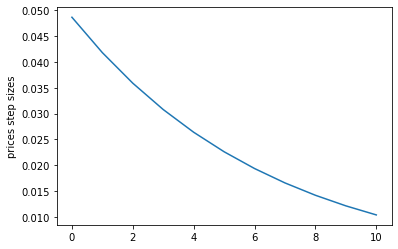

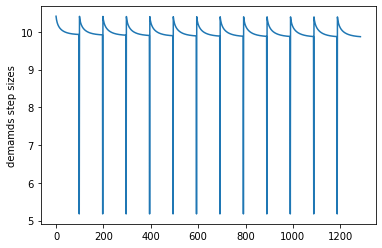

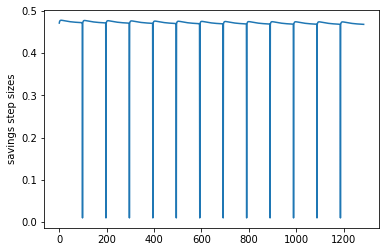

In [ ]:
num_goods = 2
num_buyers = 2
num_samples = 25
discount = 0.9

valuations = np.array([[21.26920423, 33.45640665],
 [45.06020981, 23.52635807]])



num_iters_prices = 60
num_iters_demands = 100

value_coef = np.repeat(0, num_buyers)
value_intercept = 10


budgets = np.array([9.9,9.9])


utility_type = "cd"

# negative big 
# positive small

print(np.linalg.norm(value_coef))

learn_rate_prices = 1.4
learn_rate_demands = 0.005
print(learn_rate_prices)
print(learn_rate_demands)
# prices_step_sizes, demands_step_sizes, savings_step_sizes = min_max_linear_value_cvx_project(budgets, valuations, value_coef, value_intercept, 
#                                                                                  discount, learn_rate_prices, learn_rate_demands, 
#                                                                                 num_iters_prices, num_iters_demands, utility_type)

prices_step_sizes, demands_step_sizes, savings_step_sizes = min_max_linear_value_jax(budgets, valuations, value_coef, value_intercept, 
                                                                                 discount, learn_rate_prices, learn_rate_demands, 
                                                                                num_iters_prices, num_iters_demands, utility_type, test=True)
plt.plot(prices_step_sizes[1:])
plt.ylabel("prices step sizes")
plt.show()

plt.plot(demands_step_sizes[1:])
plt.ylabel("demamds step sizes")
plt.show()

plt.plot(savings_step_sizes[1:])
plt.ylabel("savings step sizes")
plt.show()

# 9.1 -- 94.68
# 9.9 -- 102.21

In [ ]:
0.23064679292222323

#### Value Iteration

In [ ]:
# The main function for value iteration
def fitted_linear_val_iter(valuations, value_coef, value_intercept, discount, learn_rate_prices, learn_rate_demands,
                                                                    num_iters_VI, num_iters_prices,  num_iters_demands, 
                                                                    num_samples, utility_type):
    coef_hist = [value_coef]
    intercept_hist = [value_intercept]
    values_hist = []
    budgets_hist = []
    
    num_buyers = valuations.shape[0]
    num_goods = valuations.shape[1]

    budgets_samples = np.random.uniform(9, 10, (num_samples, num_buyers))
    for iter in range(num_iters_VI):
        print(f"----------Value Iteration {iter}------------")
        values = []
        
        for index, budgets in enumerate(budgets_samples): 
            print(f"_____Sample {index}_____")
            # value, prices, allocations, savings = min_max_linear_value_manual_project(budgets, valuations, value_coef, value_intercept, discount, learn_rate_prices, learn_rate_demands, num_iters_prices, num_iters_demands, utility_type)
            # real_learn_rate_prices = (np.sum(budgets) / 7.5) * learn_rate_prices * (1 / np.linalg.norm(value_coef).clip(1))
            # real_learn_rate_demands = (np.sum(budgets) / 500) * learn_rate_demands * (1 / np.linalg.norm(value_coef).clip(1))
            real_learn_rate_prices = 2.65
            real_learn_rate_demands = 0.04
            value, prices, allocations, savings = min_max_linear_value_jax(budgets, valuations, value_coef, value_intercept, 
                                                                                   discount, real_learn_rate_prices, real_learn_rate_demands, 
                                                                                   num_iters_prices, num_iters_demands, utility_type, test=False)
            values.append(value)
        
        values = np.array(values)
        

        reg = linear_model.LinearRegression()
        reg.fit(budgets_samples, values)
        value_coef = reg.coef_ # Update the parameters
        value_intercept = reg.intercept_ # Update the intercept
        
        coef_hist.append(value_coef)
        intercept_hist.append(value_intercept)
        values_hist.append(values)
        budgets_hist.append(budgets_samples)

        print("value coef:", value_coef)
        print("value_intercept:", value_intercept)
        print("---------------------------------------------------------------------------------------------------------")

        # coef_hist_filename = f"/content/drive/My Drive/exp_results_{utility_type}_new_valfunc/coef_hist_{iter}_{utility_type}_fisher.npy"
        # intercept_hist_filename = f"/content/drive/My Drive/exp_results_{utility_type}_new_valfunc/intercept_hist_{iter}_{utility_type}_fisher.npy"
        # values_hist_filename = f"/content/drive/My Drive/exp_results_{utility_type}_new_valfunc/values_hist_{iter}_{utility_type}_fisher.npy"
        # budgets_hist_filename = f"/content/drive/My Drive/exp_results_{utility_type}_new_valfunc/budgets_hist_{iter}_{utility_type}_fisher.npy"
        # with open(coef_hist_filename, 'wb') as f:
        #     np.save(f, coef_hist)

        # with open(intercept_hist_filename, 'wb') as f:
        #     np.save(f, intercept_hist)

        # with open(values_hist_filename, 'wb') as f:
        #     np.save(f, values_hist)


        # with open(budgets_hist_filename, 'wb') as f:
        #     np.save(f, budgets_hist)

    return (coef_hist, intercept_hist, values_hist, budgets_hist)


### Experiments

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

num_goods = 2
num_buyers = 2
discount = 0.9
value_coef = np.repeat(1, num_buyers)
value_intercept = 0


valuations = np.array([[21.26920423, 33.45640665],
 [45.06020981, 23.52635807]])

learn_rate_prices = 1
learn_rate_demands = 1
num_iters_VI = 30
num_iters_prices = 60 #10
num_iters_demands = 100 #20
num_samples = 25 #25



# coef_hist_linear, intercept_hist_linear, values_hist_linear, budgets_hist_linear = fitted_linear_val_iter(valuations, value_coef, value_intercept, discount, learn_rate_prices, learn_rate_demands,
#                                                                     num_iters_VI, num_iters_prices, num_iters_demands, 
#                                                                     num_samples, "cd")

# coef_hist_leontief, intercept_hist_leontief, values_hist_leontief, budgets_hist_leontief = fitted_linear_val_iter(valuations, value_coef, value_intercept, discount, learn_rate_prices, learn_rate_demands,
#                                                                     num_iters_VI, num_iters_prices, num_iters_demands, 
#                                                                     num_samples, "leontief")

coef_hist_cd, intercept_hist_cd, values_hist_cd, budgets_hist_cd = fitted_linear_val_iter(valuations, value_coef, value_intercept, discount, learn_rate_prices, learn_rate_demands, 
                                                                    num_iters_VI, num_iters_prices, num_iters_demands, 
                                                                    num_samples, "cd")


Streaming output truncated to the last 5000 lines.
Early end! Excess demand norm: 0.008848954521230093
------------------------------------------------------------------
budgets: [9.91360098 9.83996788]
demands: [[0.37311545 0.63678668]
 [0.62751146 0.3543866 ]]
prices: [10.03351553  9.26278916]
value: 90.40604
excess demands: [ 0.00062692 -0.00882672]
_____Sample 20_____

****Min-Max Price Iteration 10****
Early end! Excess demand norm: 0.007381208589298095
------------------------------------------------------------------
budgets: [9.48740239 9.07363206]
demands: [[0.38093485 0.64721922]
 [0.61583191 0.34614539]]
prices: [9.39780693 8.714106  ]
value: 89.607155
excess demands: [-0.00323324 -0.00663539]
_____Sample 21_____
Early end! Excess demand norm: 0.009440393434182267
------------------------------------------------------------------
budgets: [9.4673757 9.4240375]
demands: [[0.37105588 0.63603858]
 [0.62597628 0.35499967]]
prices: [9.62000112 8.84333668]
value: 89.842766
excess 

#### Save results

In [19]:
from google.colab import drive
drive.mount('/content/drive')


#### Save Linear data ##### 

# with open('/content/drive/My Drive/exp_results/jax_savings/coef_hist_linear_fisher.npy', 'wb') as f:
#     np.save(f, coef_hist_linear)

# with open('/content/drive/My Drive/exp_results/jax_savings/intercept_hist_linear_fisher.npy', 'wb') as f:
#     np.save(f, intercept_hist_linear)

# with open('/content/drive/My Drive/exp_results/jax_savings/values_hist_linear_fisher.npy', 'wb') as f:
#     np.save(f, values_hist_linear)

# with open('/content/drive/My Drive/exp_results/jax_savings/budgets_hist_linear_fisher.npy', 'wb') as f:
#     np.save(f, budgets_hist_linear)


##### Save Cobb-Douglas data #####
with open('/content/drive/My Drive/exp_results/jax_savings/coef_hist_cd_fisher.npy', 'wb') as f:
    np.save(f, coef_hist_cd)

with open('/content/drive/My Drive/exp_results/jax_savings/intercept_hist_cd_fisher.npy', 'wb') as f:
    np.save(f, intercept_hist_cd)

with open('/content/drive/My Drive/exp_results/jax_savings/values_hist_cd_fisher.npy', 'wb') as f:
    np.save(f, values_hist_cd)

with open('/content/drive/My Drive/exp_results/jax_savings/budgets_hist_cd_fisher.npy', 'wb') as f:
    np.save(f, budgets_hist_cd)




# ##### Save Leontief data ##### 
# with open('/content/drive/My Drive/exp_results/jax_savings/coef_hist_leontief_fisher.npy', 'wb') as f:
#     np.save(f, coef_hist_leontief)

# with open('/content/drive/My Drive/exp_results/jax_savings/intercept_hist_leontief_fisher.npy', 'wb') as f:
#     np.save(f, intercept_hist_leontief)

# with open('/content/drive/My Drive/exp_results/jax_savings/values_hist_leontief_fisher.npy', 'wb') as f:
#     np.save(f, values_hist_leontief)

# with open('/content/drive/My Drive/exp_results/jax_savings/budgets_hist_leontief_fisher.npy', 'wb') as f:
#     np.save(f, budgets_hist_leontief)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
